# Mobile Specifications - Decision Tree Classification for PBI

The following is a condensation of a jupyter notebook, prepared for compatibility with Power BI. The first set of objectives to build multiple Pandas Dataframes within Power BI. These dataframe will then be visualised in the report. 

It is highly compatable with Pandas and a select few other packages seen here: https://learn.microsoft.com/en-us/power-bi/connect-data/service-python-packages-support

## Processing script ready for PBI Power Query Editor:

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix

# 'dataset' holds the input data for this script
dataset = pd.read_csv(r"C:\Users\Yobi-Work\Documents\LBG\Sprint 1\PBI Python Decision Tree\phone class\phone_classification.csv")
dataset = dataset.dropna()

# Separate features (X) and target variable (y)
X = dataset.drop("price_range", axis=1)
y = dataset["price_range"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#############################################################
# Scaling - only necessary for numerical values, if categorical- use One-Hot Encoding

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#place in Pandas DF and drop index
X_train_scaled = pd.DataFrame(X_train_scaled).reset_index(drop=True)
X_test_scaled  = pd.DataFrame(X_test_scaled).reset_index(drop=True) 

#drop index for y
y_train_reset = y_train.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

#recreate both train and test dataframes 
train = pd.concat([X_train_scaled, y_train_reset], axis=1)
test = pd.concat([X_test_scaled, y_test_reset], axis=1)

# name the columns
train.columns = dataset.columns
test.columns = dataset.columns

# You ought to have 2 DataFrames train and test. Evaluate the quality of both in Power BI

###########################################################
# Modelling your Decision Tree

model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)


###########################################################
# Evaluating your Decision Tree model

# Generate your predictions
y_pred=model.predict(X_test_scaled) 

# Generate a Confusion Matrix as a dataframe - conf_matrix_df
conf_matrix_values = confusion_matrix(y_test, y_pred)
class_labels = ['1', '2', '3', '4']

# Create DataFrame from the confusion matrix
conf_matrix = pd.DataFrame(conf_matrix_values, index=class_labels)

##########################################################

# compile your metrics into a DataFrame - metrics_df
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
col= ['Accuracy','Recall','Precision']
metric_df = pd.DataFrame(col,[accuracy, recall, precision]).reset_index()


In [33]:
# To review in Python Notebook. Will be visualised as a simple table in PBI
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.8
Precision: 0.8085600679704871
Recall: 0.8

Confusion Matrix:
    0   1   2   3
1  91  14   0   0
2   6  70  15   0
3   0  12  67  13
4   0   0  20  92


## Visualising your model and its performance metrics in Power BI Desktop

One issue is that we are recreating the model for visualisation. We are using the exact same training dataframe and same random_state and max_depth. Making it almost exactly the same, the reason for this is due to the complexity of storing a data object as complex as a Decision Tree as a Dataframe to be visualised.

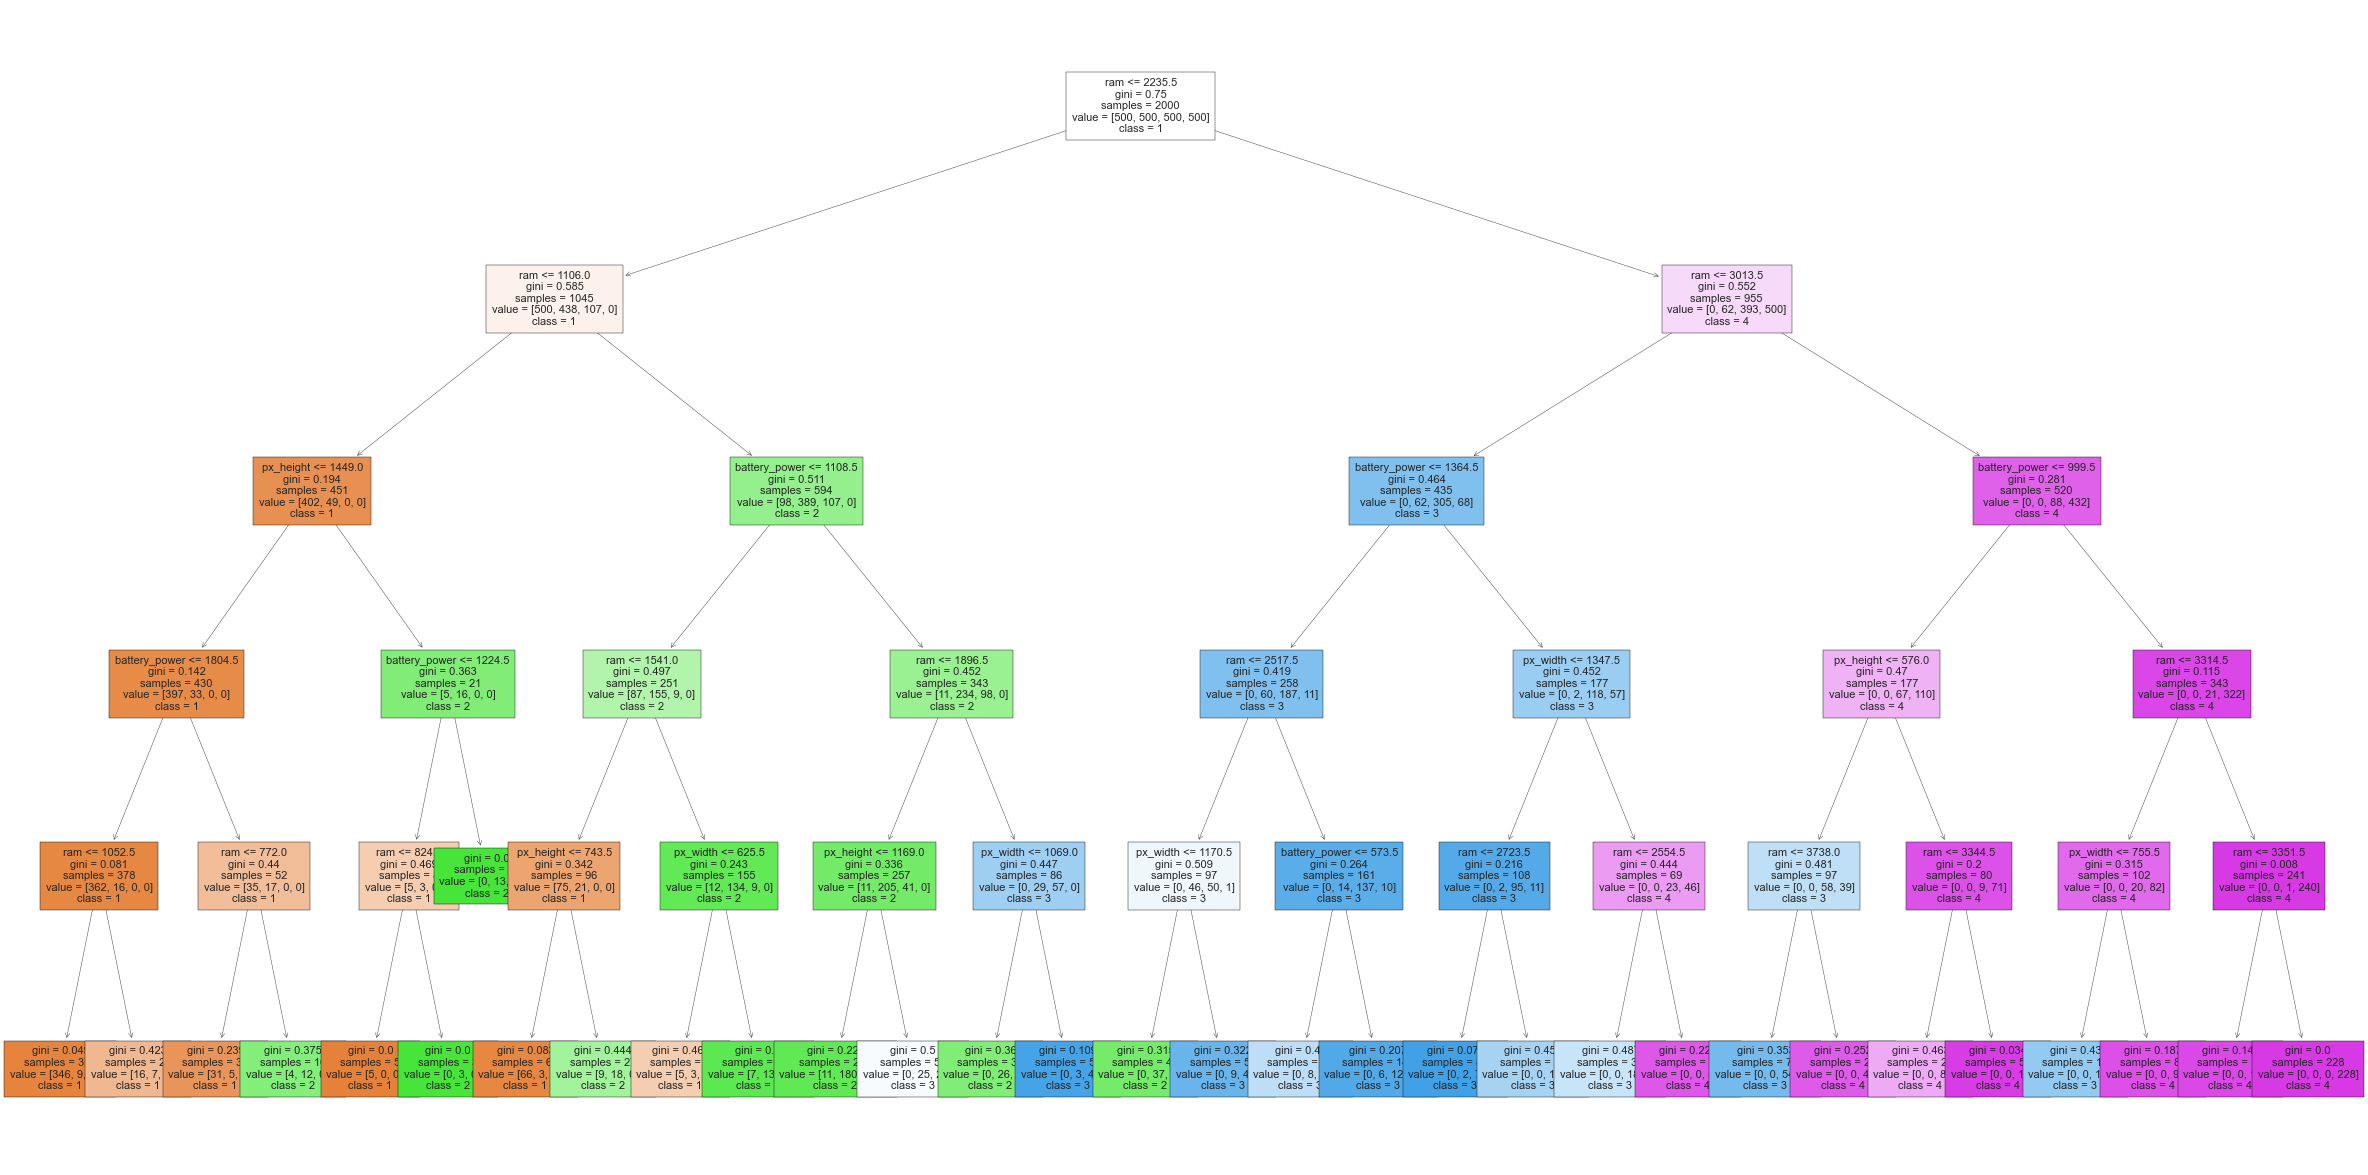

In [34]:
# Visualising your model on the report desktop. 

from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Initialize the Decision Tree Classifier

model = DecisionTreeClassifier(max_depth=5, random_state=42)

X_train = dataset.drop('price_range', axis=1)
y_train = dataset['price_range']

# Train the model on the training set
model.fit(X_train, y_train)

from sklearn import tree

c_names = ['1','2','3','4']
f_names = list(X_train.columns)


fig = plt.figure(figsize=(30,15))
vis = tree.plot_tree(model, 
                   feature_names=f_names,  
                   class_names=c_names,
                   filled=True,
                    fontsize=8)
plt.show()


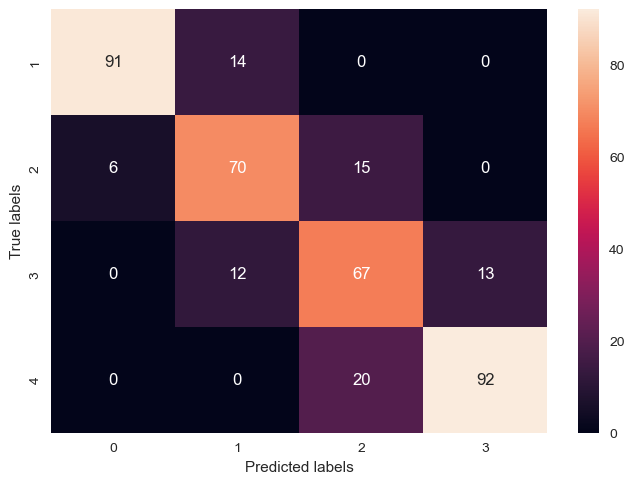

In [35]:
# Generate a Confusion Matrix as a dataframe - conf_matrix_df
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
#ax.xaxis.set_ticklabels(['4', '3', '2', '1']); ax.yaxis.set_ticklabels(['1', '2', '3', '4'])
plt.show()

In [36]:
# ROC Curve Challenge - Your marketing data has two classes Yes and No. The mobile specs data here is has multiple classes
# Your marketing data is compatible with sklearn.metrics - roc_curve, auc

C:\Users\Yobi-Work\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


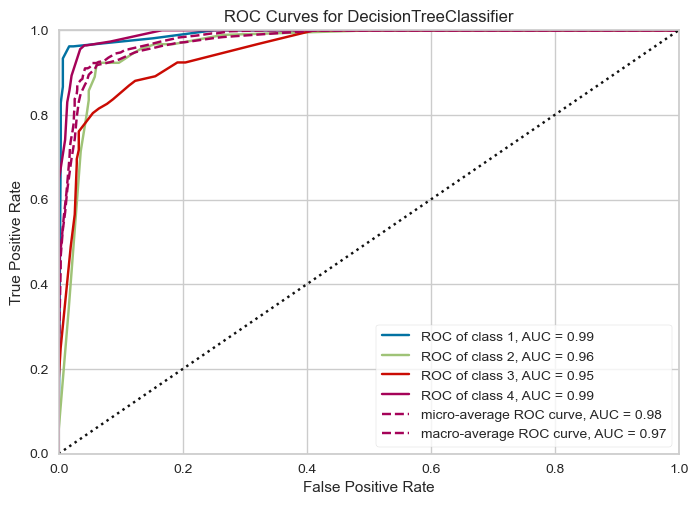

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [37]:
# Yellowbrick is compatible for multiple brick
#%pip install yellowbrick

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game


visualizer = ROCAUC(model, classes=["1", "2", "3", "4"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [38]:
# ROC Curve - that normally works with binary data
# Here for mobile_specs, the multiple classes arent readily compatible - see error below.
y_df = pd.DataFrame(list(zip(y_test, y_pred)))

# Replace 'yes' with 1 and 'no' with 0 in the entire DataFrame
y_df = y_df.replace({'yes': 1, 'no': 0})
#y_df

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_p =y_df.iloc[ : , 0 ]
y_t =y_df.iloc[ : , 1 ]

fpr, tpr, thresholds = roc_curve(y_p, y_t)
roc_auc = auc(fpr, tpr)


# Plotting the ROC Curve
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported